In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torch.nn as nn

import sys, os
from tqdm import tqdm
from skimage.transform import resize
import cv2
from PIL import Image
from numpy import asarray

In [3]:
MODELS = {
    "ViT-B/32":       "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
}

In [4]:
!wget {MODELS["ViT-B/32"]} -O model.pt

--2021-03-07 17:45:31--  https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.19, 13.107.213.19, 2620:1ec:bdf::19, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353976522 (338M) [application/octet-stream]
Saving to: ‘model.pt’

model.pt            100%[===================>] 337.58M  26.2MB/s    in 12s     

2021-03-07 17:45:43 (28.2 MB/s) - ‘model.pt’ saved [353976522/353976522]



In [5]:
model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [6]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

In [7]:
def dataload(path1,  size = (224, 224, 3)):
    """
    inputs: path to images folder
    returns: arrays contains imgs 
    """
    onlyfiles1 = [f for f in os.listdir(path1) if os.path.isfile(os.path.join(path1, f))]
    onlyfiles1.sort()

    visible = np.ndarray(shape=(len(onlyfiles1), size[0], size[1], size[2]), dtype = np.float32)
    i = 0
    for img_name in tqdm(onlyfiles1):
      img_path = path1 + "/" + img_name
      img = np.array(Image.open(img_path, mode="r").resize((size[0], size[1], size[2])))
      visible[i] = img 
    print("\t############# All VISIBLE images to array ##########")
    return visible

def dataLabels(path1):
    onlyfiles1 = [f for f in os.listdir(path1) if os.path.isfile(os.path.join(path1, f))]
    print(onlyfiles1)
    labels = []
    for img_name in tqdm(onlyfiles1):
        splits = img_name.split("_")
        if len(splits) > 1:
          label = splits[0]
          labels.append(label)

    return labels

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
cd gdrive/MyDrive/

/content/gdrive/MyDrive


In [10]:
main_path = os.path.abspath(os.getcwd())
data_dir = main_path + '/testImages_artphoto/'
print(data_dir)

/content/gdrive/MyDrive/testImages_artphoto/


In [11]:
#!mv  testImages_artphoto train
#!mkdir testImages_artphoto
#!mv train testImages_artphoto
#!cd testImages_artphoto

In [12]:
import os
from os import listdir
from os.path import isfile, join
import shutil

data_dir = '/content/gdrive/My Drive/testImages_artphoto/'

# create directory if it does not exist
def check_dir(dir_path):
    dir_path = dir_path.replace('//','/')
    os.makedirs(dir_path, exist_ok=True)

def setup():
  for f in listdir(join(data_dir, 'train')):
      # create directory if necessary
      label = f[:-9]
      path = join(data_dir, label)
      check_dir(path)
      # copy to target directory
      src_path = join(data_dir, 'train', f)
      targ_path = join(path, f)
      shutil.copy(src_path, targ_path)

In [13]:
#!rm -rf "/content/gdrive/My Drive/testImages_artphoto/train/"

In [14]:
data_dir = '/content/gdrive/My Drive/testImages_artphoto/'
dsets = datasets.ImageFolder(data_dir, preprocess)

In [15]:
print(*dsets.classes, sep='\n')

amusement
anger
awe
contentment
disgust
excitement
fear
sad


In [16]:
dsets

Dataset ImageFolder
    Number of datapoints: 806
    Root location: /content/gdrive/My Drive/testImages_artphoto/
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BICUBIC)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [46]:
data_loader = torch.utils.data.DataLoader(dsets, batch_size=8, shuffle=True, num_workers=6)

In [47]:
data_loader

In [48]:
dsets.classes

['amusement',
 'anger',
 'awe',
 'contentment',
 'disgust',
 'excitement',
 'fear',
 'sad']

In [49]:
inputs, labels = next(iter(data_loader))

In [50]:
plt.imshow(inputs[21].permute(1, 2, 0))

IndexError: ignored

In [ ]:
labels[21]

In [51]:
class_names=  ["amusement", "anger", "awe", "contentment","disgust", "excitement", "fear", "sad"]

In [52]:
#dsets has 806 samples
train_set, val_set = torch.utils.data.random_split(dsets, [600, 206])

## Text Processing

In [53]:
! pip install ftfy regex
! wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz

--2021-03-07 17:59:30--  https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.19, 13.107.213.19, 2620:1ec:bdf::19, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1356917 (1.3M) [application/octet-stream]
Saving to: ‘bpe_simple_vocab_16e6.txt.gz’

bpe_simple_vocab_16 100%[===================>]   1.29M  --.-KB/s    in 0.06s   

2021-03-07 17:59:30 (20.8 MB/s) - ‘bpe_simple_vocab_16e6.txt.gz’ saved [1356917/1356917]



In [54]:
#@title

import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text


In [55]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "amusement": "The state of being entertained, or pleased.",
    "anger": "A strong feeling that makes you want to hurt someone or be unpleasant because of something unfair or unkind that has happened",
    "awe": "to admire someone or something",
    "contentment": "Happiness and satisfaction, often because you have everything you need",
    "disgust": "A strong feeling of disapproval and dislike at a situation",
    "excitement": "A feeling of being excited",
    "fear": "An unpleasant emotion or thought that you have when you are frightened or worried by something dangerous that is happening or might happen", 
    "sad": "Showing or feeling unhappiness."
}

In [56]:
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = preprocess(Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB"))
    images.append(image)
    texts.append(descriptions[name])

    plt.subplot(2, 4, len(images))
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()


<Figure size 1152x360 with 0 Axes>

## Zero-shot prediction

In [57]:
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-1rch4x34
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-1rch4x34
  Created wheel for clip: filename=clip-1.0-cp37-none-any.whl size=1368688 sha256=35f83c69f3445d865510b3ea8501e4c5f03e0db95c597c04e8a8531f6e1c17d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-gpp5_ywf/wheels/79/51/d7/69f91d37121befe21d9c52332e04f592e17d1cabc7319b3e09
Successfully built clip


In [58]:
import numpy as np
import torch
import clip
from tqdm.notebook import tqdm

print("Torch version:", torch.__version__)

Torch version: 1.7.1+cu101


In [59]:
clip.available_models()

['RN50', 'RN101', 'RN50x4', 'ViT-B/32']

In [60]:
model, preprocess = clip.load("ViT-B/32")

In [61]:
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [62]:
def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]

### Building features

In [87]:
# images in skimage to use and their textual descriptions
descriptions_classes = {
    0: "The state of being entertained, or pleased.",
    1: "A strong feeling that makes you want to hurt someone or be unpleasant because of something unfair or unkind that has happened",
    2: "to admire someone or something",
    3: "Happiness and satisfaction, often because you have everything you need",
    4: "A strong feeling of disapproval and dislike at a situation",
    5: "A feeling of being excited",
    6: "An unpleasant emotion or thought that you have when you are frightened or worried by something dangerous that is happening or might happen", 
    7: "Showing or feeling unhappiness."
}

In [64]:
image_input = inputs.cuda()

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]

In [65]:
texts = [descriptions_classes[int(i.numpy())] for i in labels]

In [66]:
tokenizer = SimpleTokenizer()
text_tokens = [tokenizer.encode("This is " + desc) for desc in texts]

In [67]:
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
sot_token = tokenizer.encoder['<|startoftext|>']
eot_token = tokenizer.encoder['<|endoftext|>']

for i, tokens in enumerate(text_tokens):
    tokens = [sot_token] + tokens + [eot_token]
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input.cuda()

-------------------------------------------------------------------------

In [68]:
text_descriptions = [f"This is a photo of a {label}" for label in class_names]
text_tokens = [[sot_token] + tokenizer.encode(desc) + [eot_token] for desc in text_descriptions]
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)

for i, tokens in enumerate(text_tokens):
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input.cuda()
text_input.shape

torch.Size([8, 77])

In [69]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_input).float()

In [70]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [73]:
inputs.shape

torch.Size([8, 3, 224, 224])

Text(0.5, 1.0, 'Cosine similarity between text and image features')

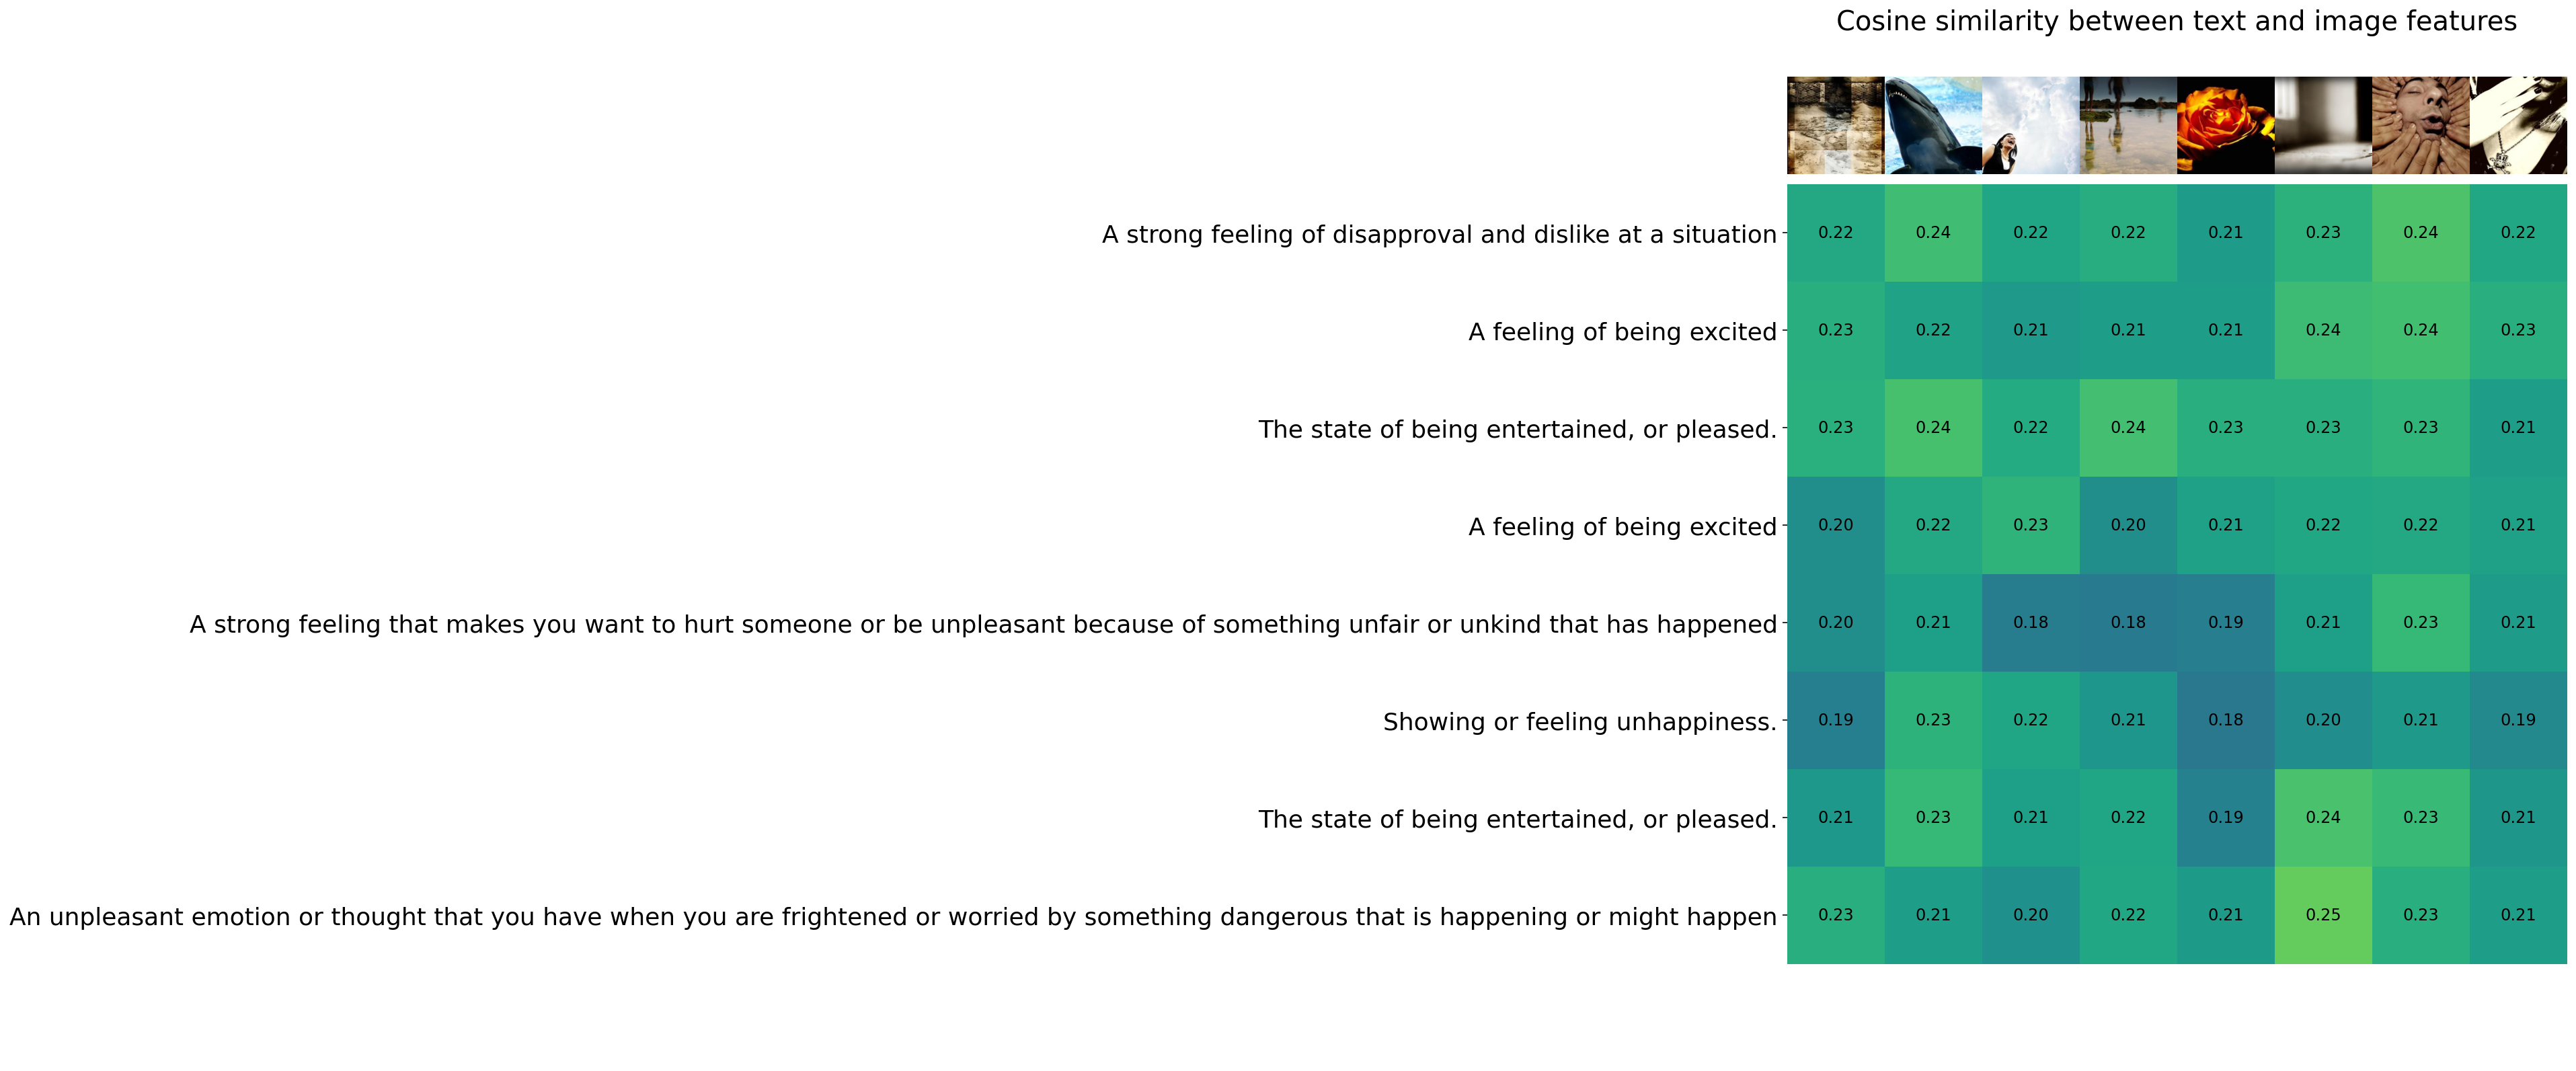

In [74]:
count = len(descriptions_classes)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(inputs):
    plt.imshow(image.permute(1, 2, 0), extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

In [75]:
with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

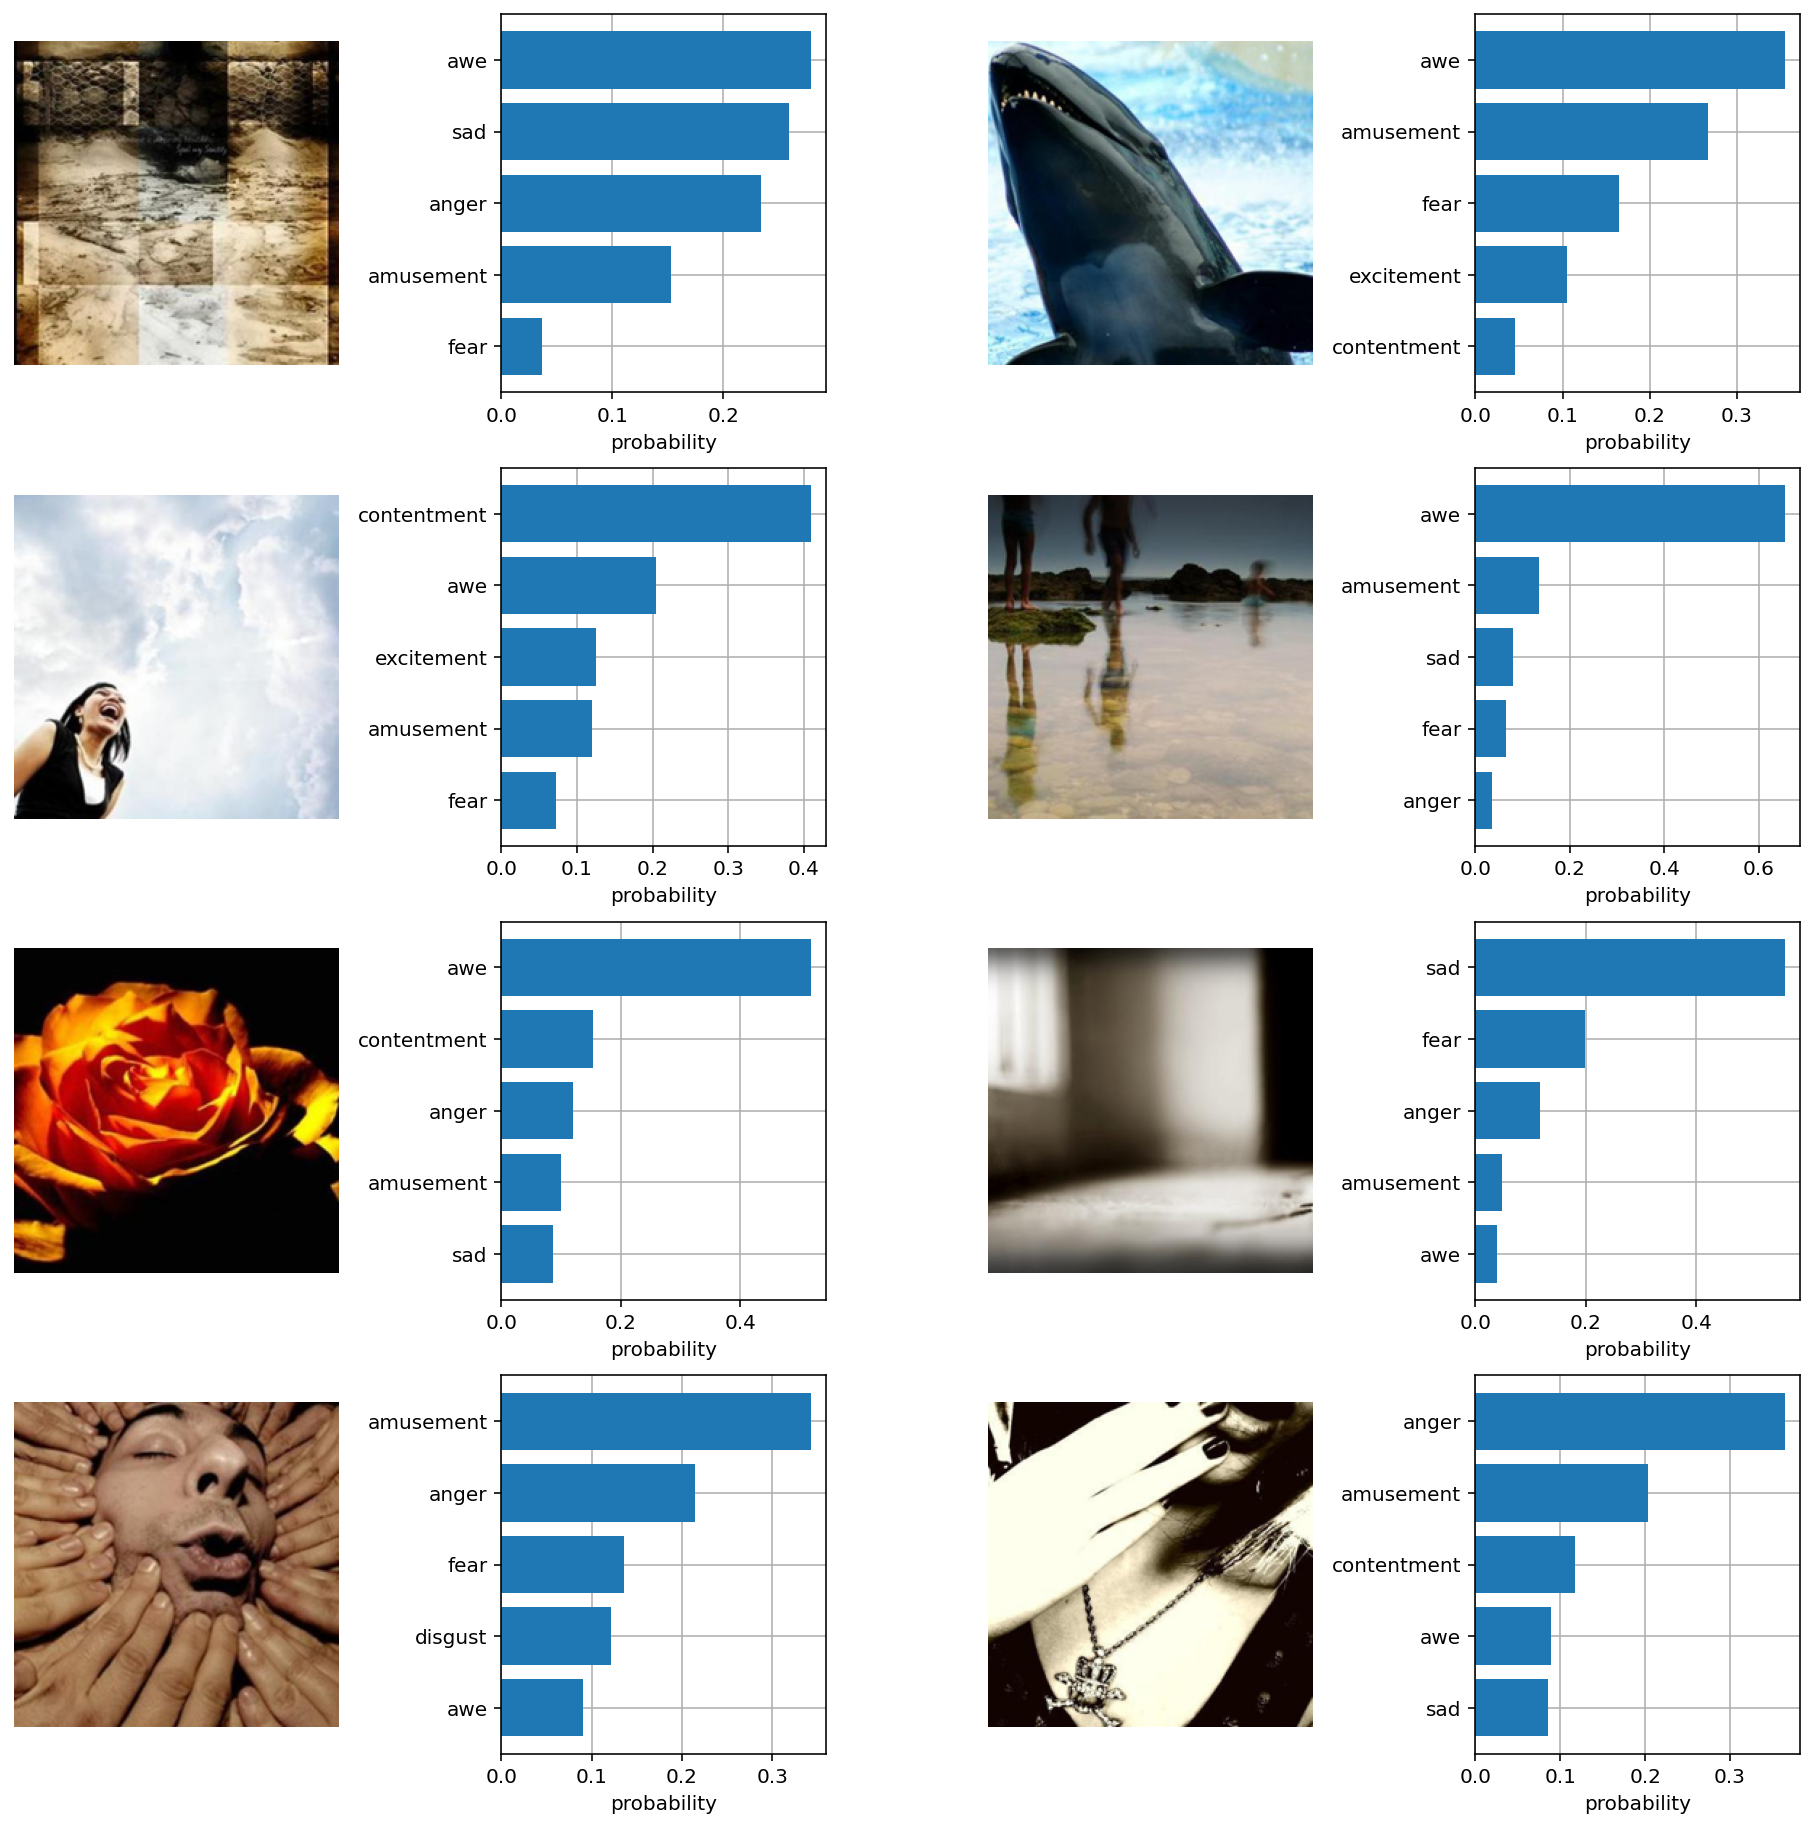

In [76]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(inputs):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [dsets.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [82]:
tokenizer = SimpleTokenizer()

sot_token = tokenizer.encoder['<|startoftext|>']
eot_token = tokenizer.encoder['<|endoftext|>']

classes = [s.replace('_', ' ') for s in dsets.classes]
text_descriptions = [f"This is a photo of a {label}" for label in classes]
text_tokens = [[sot_token] + tokenizer.encode(desc) + [eot_token] for desc in text_descriptions]
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)

for i, tokens in enumerate(text_tokens):
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input.cuda()
text_input.shape

torch.Size([8, 77])

In [83]:
text_descriptions

['This is a photo of a amusement',
 'This is a photo of a anger',
 'This is a photo of a awe',
 'This is a photo of a contentment',
 'This is a photo of a disgust',
 'This is a photo of a excitement',
 'This is a photo of a fear',
 'This is a photo of a sad']

In [84]:
with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [86]:
acc, acc_top5, count = 0, 0, 0
for i, (x, label) in enumerate(data_loader):
    
    with torch.no_grad():
        image_input = torch.tensor(np.stack(x)).cuda()
        # image_input -= image_mean[:, None, None]
        # image_input /= image_std[:, None, None]
        image_features = model.encode_image(image_input).float() 

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

    acc += (top_labels[:, 0] == label).sum()
    count += len(label)
    for k in range(5):
        acc_top5 += (top_labels[:,k] == label).sum()

    if i % 10 == 0: 
      print('%3d' %i, 'batches processed |', 
            'Accuracy is %.3f |' %(acc / count), 
            'Top 5 accuracy is %.3f' %(acc_top5 / count))
print('-'*89)
print('Accuracy is %.3f |' %(acc / count), 
      'Top 5 accuracy is %.3f' %(acc_top5 / count))

  0 batches processed | Accuracy is 0.375 | Top 5 accuracy is 0.625
 10 batches processed | Accuracy is 0.239 | Top 5 accuracy is 0.727
 20 batches processed | Accuracy is 0.274 | Top 5 accuracy is 0.750
 30 batches processed | Accuracy is 0.286 | Top 5 accuracy is 0.754
 40 batches processed | Accuracy is 0.305 | Top 5 accuracy is 0.768
 50 batches processed | Accuracy is 0.309 | Top 5 accuracy is 0.777
 60 batches processed | Accuracy is 0.316 | Top 5 accuracy is 0.783
 70 batches processed | Accuracy is 0.326 | Top 5 accuracy is 0.789
 80 batches processed | Accuracy is 0.318 | Top 5 accuracy is 0.784
 90 batches processed | Accuracy is 0.320 | Top 5 accuracy is 0.782
100 batches processed | Accuracy is 0.325 | Top 5 accuracy is 0.783
-----------------------------------------------------------------------------------------
Accuracy is 0.325 | Top 5 accuracy is 0.783


### Tune the text description for classes

In [88]:
dsets.classes

['amusement',
 'anger',
 'awe',
 'contentment',
 'disgust',
 'excitement',
 'fear',
 'sad']

In [95]:
# images in skimage to use and their textual descriptions
descriptions_classes = {
    'amusement': "The state of being entertained, or pleased.",
    'anger': "A strong feeling that makes you want to hurt someone or be unpleasant because of something unfair or unkind that has happened",
    'awe': "to admire someone or something",
    'contentment': "Happiness and satisfaction, often because you have everything you need",
    'disgust': "A strong feeling of disapproval and dislike at a situation",
    'excitement': "A feeling of being excited",
    'fear': "An unpleasant emotion or thought that you have when you are frightened or worried by something dangerous that is happening or might happen", 
    'sad': "Showing or feeling unhappiness."
}

In [96]:
tokenizer = SimpleTokenizer()

sot_token = tokenizer.encoder['<|startoftext|>']
eot_token = tokenizer.encoder['<|endoftext|>']

text_tokens = [[sot_token] + tokenizer.encode('This is a photo of ' + name + '. ' + desc)[:65] + [eot_token] 
               for name, desc in descriptions_classes.items()]
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)

for i, tokens in enumerate(text_tokens):
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input.cuda()

In [97]:
with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [98]:
acc, acc_top5, count = 0, 0, 0
for i, (x, label) in enumerate(data_loader):
    
    with torch.no_grad():
        image_input = torch.tensor(np.stack(x)).cuda()
        # image_input -= image_mean[:, None, None]
        # image_input /= image_std[:, None, None]
        image_features = model.encode_image(image_input).float()

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(3, dim=-1)

    acc += (top_labels[:, 0] == label).sum()
    # print(top_labels[:, 0], label)
    count += len(label)
    for k in range(3):
        acc_top5 += (top_labels[:,k] == label).sum()

    if i % 10 == 0: 
      print('%3d' %i, 'batches processed |', 
            'Accuracy is %.3f |' %(acc / count), 
            'Top 3 accuracy is %.3f' %(acc_top5 / count))
print('-'*85)
print('Total accuracy is %.3f |' %(acc / count), 
      'Top 3 accuracy is %.3f' %(acc_top5 / count))

  0 batches processed | Accuracy is 0.250 | Top 3 accuracy is 0.625
 10 batches processed | Accuracy is 0.250 | Top 3 accuracy is 0.557
 20 batches processed | Accuracy is 0.256 | Top 3 accuracy is 0.607
 30 batches processed | Accuracy is 0.250 | Top 3 accuracy is 0.593
 40 batches processed | Accuracy is 0.256 | Top 3 accuracy is 0.567
 50 batches processed | Accuracy is 0.257 | Top 3 accuracy is 0.569
 60 batches processed | Accuracy is 0.260 | Top 3 accuracy is 0.566
 70 batches processed | Accuracy is 0.266 | Top 3 accuracy is 0.565
 80 batches processed | Accuracy is 0.276 | Top 3 accuracy is 0.573
 90 batches processed | Accuracy is 0.272 | Top 3 accuracy is 0.574
100 batches processed | Accuracy is 0.275 | Top 3 accuracy is 0.577
-------------------------------------------------------------------------------------
Total accuracy is 0.275 | Top 3 accuracy is 0.577


#### Change Description

In [106]:
tokenizer = SimpleTokenizer()

sot_token = tokenizer.encoder['<|startoftext|>']
eot_token = tokenizer.encoder['<|endoftext|>']

text_tokens = [[sot_token] + tokenizer.encode(name + " is " + desc)[:65] + [eot_token] 
               for name, desc in descriptions_classes.items()]
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)

for i, tokens in enumerate(text_tokens):
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input.cuda()

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [107]:
acc, acc_top5, count = 0, 0, 0
for i, (x, label) in enumerate(data_loader):    
    with torch.no_grad():
        image_input = torch.tensor(np.stack(x)).cuda()
        #image_input -= image_mean[:, None, None]
        #image_input /= image_std[:, None, None]
        image_features = model.encode_image(image_input).float()

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(3, dim=-1)

    acc += (top_labels[:, 0] == label).sum()
    # print(top_labels[:, 0], label)
    count += len(label)
    for k in range(3):
        acc_top5 += (top_labels[:,k] == label).sum()

    if i % 10 == 0: 
      print('%3d' %i, 'batches processed |', 
            'Accuracy is %.3f |' %(acc / count), 
            'Top 3 accuracy is %.3f' %(acc_top5 / count))
print('-'*85)
print('Total accuracy is %.3f |' %(acc / count), 
      'Top 3 accuracy is %.3f' %(acc_top5 / count))

  0 batches processed | Accuracy is 0.125 | Top 3 accuracy is 0.625
 10 batches processed | Accuracy is 0.239 | Top 3 accuracy is 0.602
 20 batches processed | Accuracy is 0.226 | Top 3 accuracy is 0.560
 30 batches processed | Accuracy is 0.258 | Top 3 accuracy is 0.577
 40 batches processed | Accuracy is 0.280 | Top 3 accuracy is 0.588
 50 batches processed | Accuracy is 0.289 | Top 3 accuracy is 0.591
 60 batches processed | Accuracy is 0.287 | Top 3 accuracy is 0.584
 70 batches processed | Accuracy is 0.278 | Top 3 accuracy is 0.592
 80 batches processed | Accuracy is 0.275 | Top 3 accuracy is 0.582
 90 batches processed | Accuracy is 0.272 | Top 3 accuracy is 0.573
100 batches processed | Accuracy is 0.280 | Top 3 accuracy is 0.578
-------------------------------------------------------------------------------------
Total accuracy is 0.280 | Top 3 accuracy is 0.578


## Logistic Regression on Features extracted by CLIP ViT32/B

In [108]:
model, preprocess = clip.load("ViT-B/32")

In [109]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"

In [110]:
def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [111]:
import os
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader

# Calculate the image features
train_features, train_labels = get_features(train_set)
test_features, test_labels = get_features(val_set)

# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=3)
classifier.fit(train_features, train_labels)
print("Training set score: ", classifier.score(train_features, train_labels))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training set score:  0.9583333333333334


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


In [112]:
# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(np.float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Accuracy = 45.631
